In [5]:
#Read in all of the relevant libraries
import numpy as np
import pandas as pd  #Pandas is a nice package for data reading/selection
import math
import scipy as sp
import matplotlib.pyplot as plt
import ellipses as el
from scipy.spatial import ConvexHull

from IPython.display import display
import sys
import pickle
import seaborn
seaborn.set_style('ticks')
%matplotlib inline
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

This notebook is for postprocessing the large numbers of simulations we run with the metapopulations code. It takes a list of file names, reads in those simulations, then can calculate various quantities from those simulations to generate output figures. 

In [6]:
def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)

def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

In [7]:
#Codes for transforming the timeseries to polar coordinates, normalizing them, and calculating the area of a complex
#hull that encircles them.

def meanNormalize(data):
    fold = 24
    nobs = len(data)
    dates = np.linspace(0,nobs-1,nobs) 
    dates = (dates)%fold     #A year is 24 timesteps, in this code. For whatever reason.
    nyear = sum(dates==fold-1)
    theta = 2.*np.pi*((dates)/float(fold-1))
    npatch = np.shape(data)[1]  
    thresh = 1.
    data_summed = np.sum(data,axis=1)
    data_summed[data_summed<=thresh] = 0.   #Trying to ignore the 'virgin introduction spikes'
    data_summed = data_summed/float(npatch)
    data_norm = np.zeros([nobs]) 
    '''
    nhigh = 0
    for i in range(nyear):
        nhigh = np.max(data_summed[i*24:(i+1)*24])
        if nhigh ==0.:
            nhigh = 1.
        data_norm[i*24:(i+1)*24] = data_summed[i*24:(i+1)*24]/float(nhigh)   
    '''
    
    nhigh = 0 
    k = 0
    for d in dates:
        #This loop looks forward/backward 12 timesteps and finds the maximum in that window.
        if k<fold/2:
            nhigh = np.max(data_summed[0:k+fold/2])
        elif k>nobs-fold/2:
            nhigh = np.max(data_summed[k-fold/2:])
        else:
            nhigh = np.max(data_summed[k-fold/2:k+fold/2])    
        if nhigh==0.:
            nhigh += 1.5      #Don't divide by zero.
        data_norm[k] = data_summed[k]/float(nhigh)
        if nhigh==1.:   #Only one infection in this window - i.e. probably just a virgin intro. burst
            data_norm[k] = 0.
        k += 1
    
    return data_norm

def Normalize(data):
    nobs = len(data)      #How many 'observations'? (i.e. timesteps)
    dates = np.linspace(0,nobs-1,nobs) 
    dates = (dates)%24     #A year is 24 timesteps, in this code. For whatever reason.
    nyear = sum(dates==23)
    theta = 2.*np.pi*((dates)/23.)
    npatch = np.shape(data)[1]  
    data_norm = np.zeros([nobs,npatch])
    #Looks over the calendar year:
    for p in range(npatch):
        nhigh = 0
        for i in range(nyear):
            nhigh = np.max(data[i*24:(i+1)*24,p])
            if nhigh ==0.:
                nhigh = 1.
            data_norm[i*24:(i+1)*24,p] = data[i*24:(i+1)*24,p]/float(nhigh)       
        
    '''
    k = 0
    for d in dates:
        #This loop looks forward/backward 12 timesteps and finds the maximum in that window.
        if k<12:
            nhigh = np.max(data[0:k+12,p])
        elif k>nobs-12:
            nhigh = np.max(data[k-12:,p])
        else:
            nhigh = np.max(data[k-12:k+12,p])    
        if nhigh==0.:
            nhigh += 1.5      #Don't divide by zero.
        data_norm[k,p] = data[k,p]/float(nhigh)
        if nhigh==1.:   #Only one infection in this window - i.e. probably just a virgin intro. burst
            data_norm[k,p] = 0.
        k += 1
        '''
    return data_norm

def AreaCalc(data,theta,tstart=0):
    npatch = np.shape(data)[1] 
    area = []
    for i in range(npatch):
        thetafit = theta[tstart:]
        Ifit = data[tstart:,i]
        cartcoords = pol2cart(Ifit,thetafit)
        points = np.array(cartcoords)
        points = points.T
        if len(data)>1 and np.sum(data)>0.:
            hull = ConvexHull(points)
            area.append(hull.volume)
        if np.sum(data)==0.:
            area.append(np.pi)
    return area

In [49]:
#Code for fitting an ellipse to the polar timeseries using an MCMC. The mean of the fitted eccentricity is 
#the reported statistic.

#Likelihood
def eLike(p,t,d):
    fac = 2.   #factor for penalizing outside the ellipse higher than inside.
    
    e = p[0]
    a = p[1]
    phi = p[2]

    recc = a*(1.-e*e)/(1.-e*np.cos(t-phi)) #radius of the ellipse at phi
    delta = (recc-d)
    delta[delta<0.] *= fac  #apply factor to points that are outside of ellipse
    dmask = d>0.
    
    if np.sum(d)==0.:
        p[0] = 0.   #If there are no cases, the eccentricity is zero.
        p[1] = 0.25

    return -np.sum(delta[dmask]**2)  #return the sum of the differences squared (chi-squared likelihood basically)


#Jump proposals for the MCMC. Very unsophisticated but they work just fine.
def bigstep(x):
    delta = np.random.normal(loc=0.,scale=0.5,size=np.shape(x))
    y = x + delta
    return y

def smallstep(x):
    delta = np.random.normal(loc=0.,scale=0.05,size=np.shape(x))
    y = x + delta
    return y

def tinystep(x):
    delta = np.random.normal(loc=0.,scale=0.005,size=np.shape(x))
    y = x + delta
    return y


def ebigstep(x):
    delta = np.random.normal(loc=0.,scale=0.5,size=np.shape(x))
    y = x + delta
    return y

def esmallstep(x):
    delta = np.random.normal(loc=0.,scale=0.05,size=np.shape(x))
    y = x + delta
    return y

def etinystep(x):
    delta = np.random.normal(loc=0.,scale=0.005,size=np.shape(x))
    y = x + delta
    return y

In [43]:
#Take a list of files to generate an output for that list. Will be nxm long, where n and m are the number of sims
#for each of the parameters you've looped over (need to tell it n and m)You'll need to set up the filenames so that 
#they actually go in the order you want. 
#to make filelist: ls -1 *.csv | sort -t'_' -n -k2 > filelist.txt
filenames = pd.read_csv('../Sims/test2/filelist.txt',delim_whitespace=True,header=None)
n = 5  #points along first parameter
m = 5  #points along second parameter

In [44]:
#Getting the file names in a workable format
filemat = filenames.values
filemat = filemat.flatten()
npoint = len(filemat)/4
filemat = filemat.reshape([npoint,4])


In [45]:
#'toplot' is the variable that you'll be calculating in order to generate a color map. 
# options: nigh, Ipercent, ellipse, meanellipse, ecc, meanecc ('ellipse' really gives the area of the convex hull.
#'ecc' gives the eccentricity of an ellipse fitted through the data.)
#
toplot = 'ecc'  
#set up a matrix to hold the values of this variable:
plotmat = np.zeros([n,m])

In [46]:
#Select the subset of files you're going to work with (mostly for testing purposes):
'''
files_subset = []
for i in range(n):
    files_subset.append(filemat[:,n*m*i:n*m*(i+1)])
'''
#files_subset now contains nxm (x4, since there are I,S,R,and V files for each sim) 
#files for each of 10 different vaccination variance levels. If you want to make a grid looping over vacc. variance,
#you'll have to change the code quite a bit.

'\nfiles_subset = []\nfor i in range(n):\n    files_subset.append(filemat[:,n*m*i:n*m*(i+1)])\n'

In [47]:
#Select all files with the same vacc. variance.
#files = files_subset[4]
choose = 4 #which vacc. variance do you want to look at? Starts at 1, not 0.
files = filemat[n*m*(choose-1):n*m*choose,:]
print np.shape(files)
print files[0,0]

(25, 4)
cases_75_vaxvar0.5_popvar0.7_pop5000.0_0.csv


In [2]:
#This loop reads through all of the files and calculates the output variable, storing it in the plotmat matrix.
for i in range(n):
    print i
    for j in range(m):
        #Read in data file
        filenum = i*n+j%m
        print files[filenum,0]
        

        Ifile = pd.read_csv('../Sims/test2/'+files[filenum,0], delim_whitespace=True,header=0)
        Sfile = pd.read_csv('../Sims/test2/'+files[filenum,1], delim_whitespace=True,header=0)
        Rfile = pd.read_csv('../Sims/test2/'+files[filenum,2], delim_whitespace=True, header=0)
        Vfile = pd.read_csv('../Sims/test2/'+files[filenum,3], delim_whitespace=True,header=0)
        
        Idata_all = Ifile.values
        Sdata_all = Sfile.values
        Rdata_all = Rfile.values
        Vdata_all = Vfile.values
                
        Idata_all = Idata_all.astype(float)
        Sdata_all = Sdata_all.astype(float)
        Rdata_all = Rdata_all.astype(float)
        Vdata_all = Vdata_all.astype(float)
        
        tsteps = len(Idata_all[:,0])
        npatch = len(Idata_all[0,:])
        
        burnin = 0.6*len(Idata_all)
        burnin = int(burnin)
        
        Idata = Idata_all[burnin:,:]
        Sdata = Sdata_all[burnin:,:]
        Rdata = Rdata_all[burnin:,:]
        Vdata = Vdata_all[burnin:,:]
        
        '''print j
        if (j-5)%10==0:
            print files[0,filenum]
            plt.plot(Idata)
            '''
        
        #Outbreaks are identified as any string of more than one time-step during which I>0 in a cell.
        if toplot=='Ipercent': #percentage of patches infected over full timeseries
            outsize = np.zeros(npatch)
            k = 1
            while k<(tsteps-burnin):
                for r in range(npatch):
                    if Idata[k,r] > 0.:
                        if Idata[k-1,r] > 0.:
                            outsize[r] += Idata[k,r]
                k += 1

            totinf = sum(outsize)
            totpop = Idata+Sdata+Rdata+Vdata
            totpop = sum(totpop)
            fracinf = outsize/totpop
            print np.shape(outsize)

            plotmat[i,j] = max(fracinf)

        if toplot=='nhigh': #number of timesteps in which there is infection present (either by individual patch 
                            #or over the entire metapopulation)
            nhigh = 0
            k = 0
            while k<(tsteps-burnin):
                Ifrac = Idata[k,:]/(Idata[k,:]+Sdata[k,:]+Rdata[k,:]+Vdata[k,:])
                mask = Ifrac>=0.0
                Ihigh = Ifrac[mask]
                x = Ihigh*1.
                nhigh += len(x)
                k+=1
            plotmat[i,j] = nhigh
            
        if toplot=='ellipse':   #average area of convex hull around each patch's timeseries in polar coordinates.
            nobs = len(Idata)      #How many 'observations'? (i.e. timesteps)
            dates = np.linspace(0,nobs-1,nobs) 
            dates = (dates)%24     #A year is 24 timesteps, in this code. For whatever reason.
            theta = 2.*np.pi*((dates+1)/24.)
            Idata_normed = Normalize(Idata)
            Areas = AreaCalc(Idata_normed)
            plotmat[i,j] = np.mean(Areas)
            
        if toplot=='meanellipse': #area of convex hull around sum of all patches in polar coordinates
            nobs = len(Idata)      #How many 'observations'? (i.e. timesteps)
            dates = np.linspace(0,nobs-1,nobs) 
            dates = (dates)%24     #A year is 24 timesteps, in this code. For whatever reason.
            theta = 2.*np.pi*((dates)/(24.-1))
            Idata_normed = meanNormalize(Idata)
            Idata_normed = Idata_normed.reshape([len(Idata_normed),1])
            Areas = AreaCalc(Idata_normed,theta,tstart=100)
            plotmat[i,j] = np.mean(Areas)
            
        if toplot=='ecc': #eccentricity of ellipse fitted to polar data of timeseries sum of patches
            Idata[Idata>0] -= 1
            Idata_norm = Normalize(Idata)
            fold = 24
            nobs = len(Idata_norm[:])
            dates = np.linspace(0,nobs-1,nobs) 
            dates = (dates)%fold     #Wrap the data every fold steps
            angle = 2.*np.pi*((dates)/float(fold-1))
            
            
            
            #select the nyear final years of data set
            nyear = 15
            t = angle[-nyear*24:]
            e = []
            npatch = np.shape(Idata)[1]
            for p in range(npatch):
                
                if p%50==0:
                    print i,j,p
                
                r = Idata_norm[-nyear*24:,p]
                #starting point/likelihood for the train
                p0 = np.array([0.,0.5,0.])
                like0 = eLike(p0,t,r)

                params = p0.copy()
                Nstep = 5000  #number of steps for the MCMC

                chain = []
                chain.append(p0)

                Lchain = []
                Lchain.append(like0)
                for step in range(Nstep):
                    s = np.random.rand(1)
                    if s>0.75:
                        ptry = ebigstep(params)
                    elif s>0.5:
                        ptry = etinystep(params)
                    else:
                        ptry = esmallstep(params)

                    #enforce periodic prior on phi:
                    if ptry[2]>2.*np.pi:
                        ptry[2] -= 2.*np.pi

                    if ptry[2]<0.:
                        ptry[2] += 2.*np.pi
                    like_try = eLike(ptry,t,r)
                    #eccentricity is between 0 and 1:
                    if ptry[0] >1.:
                        like_try = -np.inf
                    if ptry[0] <0.:
                        like_try = -np.inf

                    #Hastings ratio
                    H = np.random.rand(1)
                    h = np.exp(like_try - like0)

                    if H<h:
                        params = ptry
                        like0 = like_try

                    chain.append(params)
                    Lchain.append(like0)

                chain = np.array(chain)
                chain = np.array(chain)
                epatch = np.mean(chain[500:,0])
                
                e.append(epatch)
            
            e = np.array(e)
            mask = e==0.
            plotmat[i,j] = np.mean(e[~mask])          
            
        if toplot=='meanecc': #eccentricity of ellipse fitted to polar data of timeseries sum of patches
            Idata[Idata>0] -= 1
            
            Idata_norm = meanNormalize(Idata)
            fold = 24
            nobs = len(Idata_norm[:])
            dates = np.linspace(0,nobs-1,nobs) 
            dates = (dates)%fold     #Wrap the data every fold steps
            angle = 2.*np.pi*((dates)/float(fold-1))
            
            #select the nyear final years of data set
            nyear = 15
            r = Idata_norm[-nyear*24:]
            t = angle[-nyear*24:]
            
            #starting point/likelihood for the train
            p0 = np.array([0.,0.5,0.])
            like0 = eLike(p0,t,r)

            params = p0.copy()
            Nstep = 10000  #number of steps for the MCMC

            chain = []
            chain.append(p0)

            Lchain = []
            Lchain.append(like0)
            for step in range(Nstep):
                s = np.random.rand(1)
                if s>0.75:
                    ptry = ebigstep(params)
                elif s>0.5:
                    ptry = etinystep(params)
                else:
                    ptry = esmallstep(params)

                #enforce periodic prior on phi:
                if ptry[2]>2.*np.pi:
                    ptry[2] -= 2.*np.pi

                if ptry[2]<0.:
                    ptry[2] += 2.*np.pi
                like_try = eLike(ptry,t,r)
                #eccentricity is between 0 and 1:
                if ptry[0] >1.:
                    like_try = -np.inf
                if ptry[0] <0.:
                    like_try = -np.inf

                #Hastings ratio
                H = np.random.rand(1)
                h = np.exp(like_try - like0)

                if H<h:
                    params = ptry
                    like0 = like_try

                chain.append(params)
                Lchain.append(like0)

            chain = np.array(chain)
            chain = np.array(chain)
            e = np.mean(chain[500:,0])
            
            plotmat[i,j] = e


NameError: name 'n' is not defined

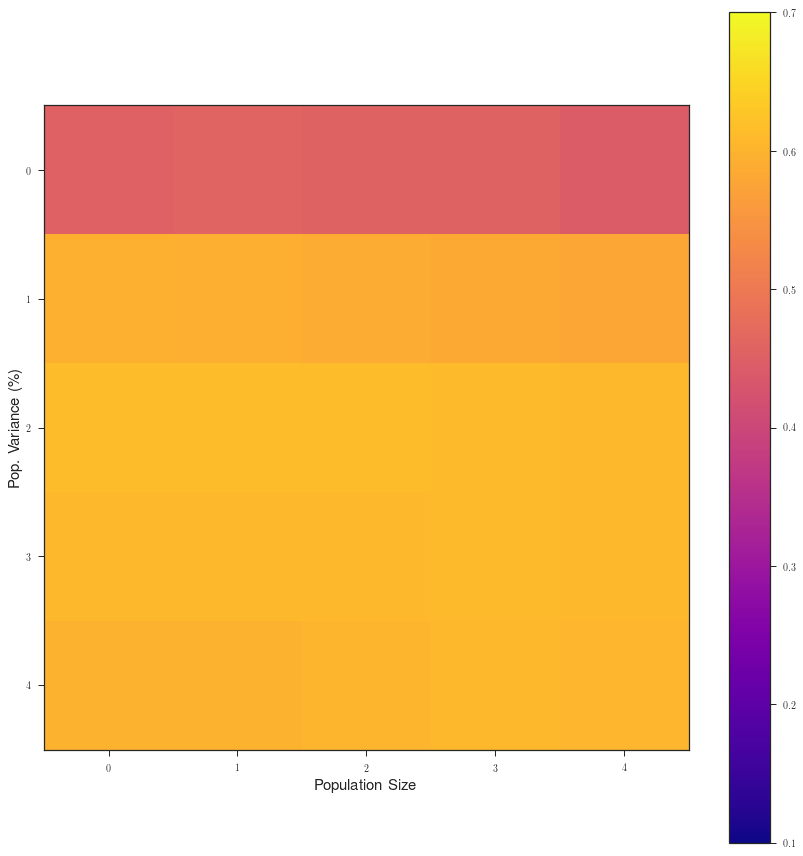

In [56]:
#print out a heatmap of the output variable.
matrix = plotmat.copy();
fig, ax = plt.subplots(figsize=(12,12))
cax = ax.imshow((matrix), interpolation='nearest', cmap='plasma',vmin=0.1,vmax=0.7)
ax.set_xticks(np.arange(0,n,1))
ax.set_yticks(np.arange(0,m,1))
#ax.set_xticklabels(['50k','56k','61k','67k','72k','78k','83k','89k','94k','100k'],fontsize=12)
#ax.set_yticklabels([1.0,3.1,5.2,7.3,9.4,11.5,13.7,15.8,17.9,20.],fontsize=12)
ax.set_xlabel('Population Size',fontsize=15)
ax.set_ylabel('Pop. Variance (\%)',fontsize=15)

# Add colorbar, make sure to specify tick locations to match desired ticklabels
cbar = fig.colorbar(cax)
#cbar.ax.set_yticklabels(['< -1', '0', '> 1'])  # vertically oriented colorbar
fig.tight_layout()

#plt.savefig('../Sims/alpha10c0.1/test.pdf')

In [57]:
print plotmat

[[0.45534217 0.45893143 0.4563409  0.45660375 0.44351563]
 [0.59528791 0.59231569 0.58954476 0.58422429 0.57955816]
 [0.61363658 0.61386194 0.61374446 0.61111812 0.60769136]
 [0.60719138 0.60805902 0.60969919 0.61279034 0.60920041]
 [0.59731619 0.59831161 0.60171604 0.60635485 0.60619539]]
